Projeto Final da disciplina EA979 da Unicamp

Aluno: Fernando Brasil Sales

Professora: Paula Costa

O objetivo deste notebook é explorar, com exemplos, o algoritmo de compressão de imagens DCT com quantização e RLE.

Ele não objetiva transformar uma imagem em um arquivo JPEG no final.

Todos os cálculos intermediários forma executados usando float64. Numa implementação prática do algoritmo seria usada uma precisão menor, para maior rapidez e menor uso de recursos de hardware.

As funções criadas aqui não foram implementadas buscando máxima eficiência.

Todas as linhas de código aqui são de minha autoria.

Algumas simplificações foram adotadas:

* Não foi implementada a Codificação de Huffman após o RLE;

* Não foi implementado Chroma Subsampling, pois queríamos ver o resultado obtido apenas com a quantização;

* Imagens com resolução não múltiplas de 8x8 sofrem corte nos pixels excedentes à direita e em baixo;

* A função teste_img() não aceita imagens com Alpha Channel.


Inicialmente importamos alguns pacotes, funções e constantes.

Também definimos a precisão e o modo com que valores float de objetos NumPy serão impressos.

In [ ]:
# importa alguns pacotes, funções e constantes
import numpy as np
from numpy import abs, cos, sqrt, pi
from PIL import Image

# configura a precisão (quantidade de casas decimais) e o modo de exibição de valores float de objetos NumPy
np.set_printoptions(precision=3, floatmode='maxprec')

A seguinte função será usada para redimensionar imagens, em particular para ampliá-las sem interpolação.

In [ ]:
# redimensiona a imagem da matriz 'b' (origem) para a matriz 'a' (destino)
def redimensiona_imagem(a, b):
    escala_vertical   = a.shape[0] / b.shape[0]
    escala_horizontal = a.shape[1] / b.shape[1]
    for linha in range(a.shape[0]):
        for coluna in range(a.shape[1]):
            a[linha, coluna] = b[int(linha/escala_vertical), int(coluna/escala_horizontal)]

No bloco de código abaixo, criamos as funções que executam DCT e IDCT em um bloco 8x8. A função 'dct8x8(p)' recebe uma matriz 'p' 8x8 de pixels monocromáticos (preferencialmente no intervalo de -128 a +127) e retorna uma matriz 'dct' 8x8 com os coeficientes DCT. A função 'idct8x8(dct)' realiza a operação inversa. Cada uma dessas funções corresponde a quatro laços 'for' aninhados. As coordenadas 'x' e 'y' são as coordenadas espaciais na matriz 'p', enquanto que 'u' e 'v' são as coordenadas na matriz 'dct'.

Examinando a fórmula do DCT no código abaixo, verificamos que o coeficiente DCT na posição (u, v), com u e v inteiros de 0 a 7, corresponde a um cosseno de frequência fu = u / 16 na direção u, e um cosseno de frequência fv = v / 16 na direção v.

Essas frequências 'f' são em unidades de ciclos/pixel.

Portanto, na posição (u, v) = (0, 0), no canto superior esquerdo da matriz de DCTs, temos fu = fv = 0, ou seja, frequências nulas em ambas as direções u e v. Sabemos que o valor médio dos 64 pixels do bloco 8x8 é o somatório dos 64 valores de p[x, y] dividido por 64. E examinando a fórmula do DCT, verificamos que dct[u=0, v=0] é o somatório de todos os 64 valores de p[x, y] dividido por 8. Portanto, concluimos que dct[u=0, v=0] é 8 vezes o valor médio dos 64 pixels do bloco 8x8.

Como em geral o valor médio dos 64 pixels de um bloco 8x8 é um valor intermediário entre os valors mínimo e máximo possíveis, para diminuirmos o valor de dct[u=0, v=0] usamos valores de pixel na faixa de -128 a +127. Portanto se os pixels estiverem inicialmente na faixa de 0 a 255, subtraimos 128 de todos os valores antes de aplicar o DCT. Essa operação em geral diminuirá os requisitos de faixa dinâmica ('dynamic range requirements'). E após realizarmos o IDCT, se quisermos obter de volta pixels na faixa de 0 a 255, devemos somar 128.

Na linha superior da matriz de DCTs, isto é com u = 0, só temos frequências na direção v horizontal: fv = 0 na coluna 0 (primeira coluna), fv = 1/16 na coluna 1 (segunda coluna), até fv = 7/16 na coluna 7 (oitava coluna).

Analogamente, na coluna à esquerda da matriz de DCTs, isto é com v = 0, só temos frequências na direção u vertical: fu = 0 na linha 0 (primeira linha), fu = 1/16 na linha 1 (segunda linha), até fu = 7/16 na linha 7 (oitava linha).

Nas posições da matriz de DCTs fora da linha superior e fora da coluna esquerda, ou seja com u e v ambos diferentes de 0, temos simultaneamente frequências nas direções vertical e horizontal.

Em um cosseno de frequência igual a 1/2 ciclo/pixel teríamos um semi-período (um salto de um vale, em -1, para o próximo pico, em +1) entre dois pixels adjacentes. Com uma amplitude de 127.5 nessa frequência, seria possível saltar de -127.5 a +127.5 (ou de -128 a +127, ou de 0 a 255) entre dois pixels adjacentes. Isso seria suficiente para codificar qualquer salto entre dois pixels vizinhos. Porém, como já dito anteriormente, a máxima frequência possível no DCT, que ocorre na oitava coluna ou na oitava linha, é uma frequência de 7/16 ciclos/pixel, que é ligeiramente inferior a 8/16 = 1/2 ciclo/pixel. Porém veremos na prática que, com frequências de até 7/16 ciclos/pixel conseguimos codificar sem perdas saltos de 0 a 255 entre dois pixels adjacentes.

In [ ]:
# (x, y): coordenadas espaciais no domínio dos pixels
# (u, v): coordenadas no domínio da frequência
# p: matriz 8x8 de pixels monocromáticos, preferencialmente no intervalo [-128, +127]
# dct: matriz 8x8 de coeficientes DCT

# 2D 8x8 Discrete Cosine Transform
def dct8x8(p):
    dct = np.zeros((8, 8), 'float64')
    alpha = np.array( [1/sqrt(2), 1, 1, 1, 1, 1, 1, 1], 'float64' )
    for u in range(8):
        for v in range(8):
            for x in range(8):
                for y in range(8):
                    dct[u, v] += 0.25 * alpha[u] * alpha[v] * p[x, y] * cos(u*pi*(2*x + 1) / 16.0) * cos(v*pi*(2*y + 1) / 16.0)
    return dct

# 2D 8x8 Inverse Discrete Cosine Transform
def idct8x8(dct):
    p = np.zeros((8, 8), 'float64')
    alpha = np.array( [1/sqrt(2), 1, 1, 1, 1, 1, 1, 1], 'float64' )
    for x in range(8):
        for y in range(8):
            for u in range(8):
                for v in range(8):
                    p[x, y] += 0.25 * alpha[u] * alpha[v] * dct[u, v] * cos(u*pi*(2*x + 1) / 16.0) * cos(v*pi*(2*y + 1) / 16.0)
    return p

A seguir criamos uma matriz 'p1' 8x8 de pixels monocromáticos com valores aleatórios na faixa de -127 a +127 em ponto flutuante de 64 bits ('float64'). Então executamos DCT em 'p1' e logo em seguida aplicamos IDCT no resultado anterior para testar se conseguimos obter de volta a matriz 'p1' original.

In [ ]:
# ruído aleatório 8x8 no intervalo de -128 a +127
p1 = 256.0 * np.random.random((8, 8)) - 128.0
p1 = p1.astype('int8')
print('Ruído aleatório 8x8 no intervalo de -128 a +127:')
print('\np1.dtype =', p1.dtype)
print('p1 =')
print(p1)

# aplicamos dct em p1 e logo em seguida idct
p1_dct_idct = idct8x8(dct8x8(p1))
print('\nAplicando dct em p1, e em seguida aplicando idct:')
print('\np1_dct_idct.dtype =', p1_dct_idct.dtype)
print('p1_dct_idct =')
print(p1_dct_idct)

# comparamos o resultado com p1
print('\nMáximo erro absoluto entre p1 e p1_dct_idct:')
print('\nabs(p1_dct_idct - p1).max() =', abs(p1_dct_idct - p1).max())

Vamos agora testar se o DCT consegue codificar perfeitamente, sem perdas, saltos de -128 a +127 (ou de 0 a 255) entre dois pixels vizinhos.

Primeiramente, saltos na horizontal.

In [ ]:
# matriz 8x8 com saltos de 0 a 255 entre pixels vizinhos de uma mesma linha
p2_uint8 = np.array( [[0, 255, 0, 255, 0, 255, 0, 255],
                      [0, 255, 0, 255, 0, 255, 0, 255],
                      [0, 255, 0, 255, 0, 255, 0, 255],
                      [0, 255, 0, 255, 0, 255, 0, 255],
                      [0, 255, 0, 255, 0, 255, 0, 255],
                      [0, 255, 0, 255, 0, 255, 0, 255],
                      [0, 255, 0, 255, 0, 255, 0, 255],
                      [0, 255, 0, 255, 0, 255, 0, 255]], 'float64' )

# matriz 8x8 com saltos de -128 a +127 entre pixels vizinhos de uma mesma linha
p2 = p2_uint8 - 128
print('p2.dtype =', p2.dtype)
print('p2 =')
print(p2)

# aplicamos dct em p2 e logo em seguida idct
p2_dct = dct8x8(p2)
p2_dct_idct = idct8x8(p2_dct)
print('\nAplicando dct em p2, e em seguida aplicando idct:')
print('\np2_dct_idct.dtype =', p2_dct_idct.dtype)
print('p2_dct_idct =')
print(p2_dct_idct)

# comparamos o resultado com p2
print('\nMáximo erro absoluto entre p2 e p2_dct_idct:')
print('\nabs(p2_dct_idct - p2).max() =', abs(p2_dct_idct - p2).max())

# matriz de coeficientes DCT de p2 com valores arredondados
p2_dct = np.around(p2_dct).astype('int32')
print('\nMatriz de DCTs de p2 (com valores arredondados para melhor visualização):')
print('\np2_dct =')
print(p2_dct)

Na matriz de DCTs de p2 acima verificamos que:

- dct[0, 0] = -4, que é 8 vezes o valor médio -0.5 da matriz de pixels, como esperado

- Só temos frequências horizontais (linha superior da matriz de DCTs), e apenas nas frequências das colunas ímpares (1, 3, 5 e 7), correspondentes respectivamente a 1/16 ciclo/pixel, 3/16 ciclos/pixel, 5/16 ciclos/pixel e 7/16 ciclos/pixel

- Os coeficientes DCT podem assumir valores que fogem da faixa dos inteiros de 8 bits; a representação típica para eles é de inteiros de 16 bits

Vamos agora aplicar DCT diretamente em p2_uint8 e comparar com o resultado anterior.

In [ ]:
print('p2_uint8.dtype =', p2_uint8.dtype)
print('p2_uint8 =')
print(p2_uint8)

# aplicamos dct em p2_uint8 e logo em seguida idct
p2_uint8_dct = dct8x8(p2_uint8)
p2_uint8_dct_idct = idct8x8(p2_uint8_dct)

# matriz de coeficientes DCT de p2_uint8 com valores arredondados
p2_uint8_dct = np.around(p2_uint8_dct).astype('int32')
print('\nMatriz de DCTs de p2_uint8 (com valores arredondados para melhor visualização):')
print('\np2_uint8_dct =')
print(p2_uint8_dct)

Vemos que a matriz de DCTs continua quase a mesma quando usamos pixels na faixa de 0 a 255, exceto dct[0, 0] que mudou para 1020, que é 8 vezes o valor médio 127.5 da matriz de pixels, como esperado.

Abaixo, saltos de -128 a +127 (ou de 0 a 255) entre dois pixels vizinhos na vertical.

In [ ]:
# matriz 8x8 com saltos de -128 a +127 entre pixels vizinhos de uma mesma coluna
p3 = p2.transpose()
print('p3.dtype =', p3.dtype)
print('p3 =')
print(p3)

# aplicamos dct em p3 e logo em seguida idct
p3_dct = dct8x8(p3)
p3_dct_idct = idct8x8(p3_dct)
print('\nAplicando dct em p3, e em seguida aplicando idct:')
print('\np3_dct_idct.dtype =', p3_dct_idct.dtype)
print('p3_dct_idct =')
print(p3_dct_idct)

# comparamos o resultado com p3
print('\nMáximo erro absoluto entre p3 e p3_dct_idct:')
print('\nabs(p3_dct_idct - p3).max() =', abs(p3_dct_idct - p3).max())

# matriz de coeficientes DCT de p3 com valores arredondados
p3_dct = np.around(p3_dct).astype('int32')
print('\nMatriz de DCTs de p3 (com valores arredondados para melhor visualização):')
print('\np3_dct =')
print(p3_dct)

Verificamos que a matriz de coeficientes DCT de p3 é a transposta da matriz de coeficientes DCT de p2.

A maneira como foram codificadas as funções de DCT e IDCT é bastante ineficiente. No caso de blocos 8x8, temos 2 * 8^4 = 8192 cálculos de cosseno por bloco, e pior, muitos deles são repetidos.

Em uma imagem com 3072x4096 pixels (12 megapixels) temos 196.608 blocos 8x8 por canal de cor, portanto 196.608 * 8192 = 1.610.612.736 cálculos de cosseno por canal de cor. Quase 5 bilhões de cossenos se contabilizarmos três canais de cores (RGB)! Isso para uma única imagem com 12 megapixels!

Existe uma maneira mais eficiente de codificar as funções de DCT e IDCT, usando duplo produto matricial. Primeiro precisamos calcular a matriz de transformação T.

In [ ]:
# matriz de transformação 8x8 para calcularmos DCT e IDCT de forma eficiente com duplo produto matricial
T8x8 = np.zeros((8, 8), 'float64')

for i in range(8):
    for j in range(8):
        if (i == 0):
            T8x8[i, j] = 1 / sqrt(8)
        else:
            T8x8[i, j] = 0.5 * cos(i*pi*(2*j + 1) / 16.0)

print('T8x8.dtype =', T8x8.dtype)
print('T8x8 =')
print(T8x8)

Os vetores-coluna dessa matriz de transformação formam um conjunto ortonormal, portanto trata-se de uma matriz ortogonal. Então sua inversa é a sua própria transposta, e o produto matricial dela por sua transposta deve resultar na matriz identidade.

In [ ]:
T8x8_transp = T8x8.transpose()
I8 = np.array( [[1, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 0, 1]], 'float64' )

# o produto matricial entre T8x8 e sua transposta deve resultar na matriz identidade I8
print('O produto matricial entre T8x8 e sua transposta deve resultar na matriz identidade I8.')
print('\nMáximo erro absoluto entre I8 e o produto matricial entre T8x8 e T8x8.transpose() =', \
      abs(I8 - np.matmul(T8x8, T8x8_transp)).max())

A maneira de calcular DCT e IDCT usando essa matriz de transformação é muito simples:

- DCT:  D = T P T'

- IDCT: P = T' D T

onde D é a matriz de coeficientes DCT, T é a matriz de transformação e P é a matriz de pixels.

In [ ]:
# 2D 8x8 Discrete Cosine Transform
# versão otimizada usando duplo produto matricial com matriz de transformação T
def dct8x8T(p):
    return np.matmul(np.matmul(T8x8, p), T8x8_transp)

# 2D 8x8 Inverse Discrete Cosine Transform
# versão otimizada usando duplo produto matricial com matriz de transformação T
def idct8x8T(dct):
    return np.matmul(np.matmul(T8x8_transp, dct), T8x8)

Vamos comparar os dois métodos de DCT, usando a mesma matriz 'p1' do primeiro exemplo.

In [ ]:
# aplicamos DCT em p1 usando o primeiro método (8192 cálculos de cosseno)
p1_dct1 = dct8x8(p1)

# aplicamos DCT em p1 usando o segundo método (duplo produto matricial)
p1_dct2 = dct8x8T(p1)

# comparamos os dois resultados
print('Máximo erro absoluto entre p1_dct1 e p1_dct2:')
print('\nabs(p1_dct1 - p1_dct2).max() =', abs(p1_dct1 - p1_dct2).max())

Agora vamos comparar os dois métodos de IDCT, usando a mesma matriz 'p1_dct1' do exemplo anterior.

In [ ]:
# aplicamos IDCT em p1_dct1 usando o primeiro método (8192 cálculos de cosseno)
p1_dct1_idct1 = idct8x8(p1_dct1)

# aplicamos IDCT em p1_dct1 usando o segundo método (duplo produto matricial)
p1_dct1_idct2 = idct8x8T(p1_dct1)

# comparamos os dois resultados
print('Máximo erro absoluto entre p1_dct1_idct1 e p1_dct1_idct2:')
print('\nabs(p1_dct1_idct1 - p1_dct1_idct2).max() =', abs(p1_dct1_idct1 - p1_dct1_idct2).max())

Agora que já sabemos calcular o DCT e o IDCT em um bloco 8x8 de forma eficiente com um duplo produto matricial, vamos investigar o significado dos coeficientes obtidos com a aplicação do DCT.

Na Wikipedia (https://en.wikipedia.org/wiki/JPEG) é dito que: "o DCT transforma um bloco 8x8 de valores de entrada em uma combinação linear desses 64 padrões. Esses padrões são chamados de funções-base, e os valores de saída do DCT são chamados de coeficientes da transformação."

Os 64 padrões, ou 64 funções-base, ou ainda 64 imagens-base, a que o texto se refere são as 64 imagens menores (delimitadas por traços vermelhos) que compõem a imagem grande abaixo.

Portanto, o algoritmo DCT 8x8 decompõe um bloco 8x8 de pixels em uma combinação linear dessas 64 imagens-base, fornecendo os coeficientes dessa combinação linear.

O IDCT 8x8, por sua vez, recupera a imagem original 8x8 por meio da aplicação da combinação linear dessas 64 imagens-base usando os respectivos coeficientes DCT.

64 imagens-base do DCT 8x8 (fonte: Wikipedia):

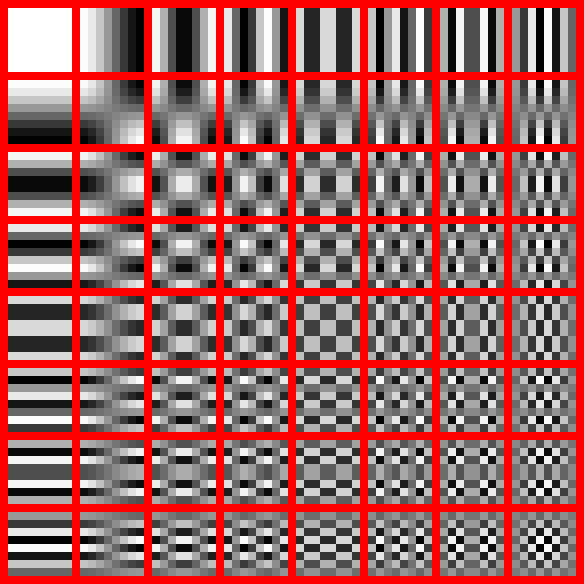

Vamos tentar construir a imagem acima. Para obtermos a imagem-base da linha i, coluna j, vamos aplicar IDCT usando uma matriz de coeficientes onde todos os 64 valores são zero exceto o coeficiente da linha i, coluna j. Faremos isso para todas as 64 posicões.

Vamos primeiro fazer alguns testes.

In [ ]:
# obtendo a imagem-base da linha 0, coluna 0
dct = np.zeros((8, 8), 'float64')
dct[0, 0] = 1.0
imagem_base00 = idct8x8T(dct)
print('imagem_base[0, 0] =')
print(imagem_base00)

# obtendo a imagem-base da linha 0, coluna 7
dct = np.zeros((8, 8), 'float64')
dct[0, 7] = 1.0
imagem_base07 = idct8x8T(dct)
print('\nimagem_base[0, 7] =')
print(imagem_base07)

# obtendo a imagem-base da linha 7, coluna 7
dct = np.zeros((8, 8), 'float64')
dct[7, 7] = 1.0
imagem_base77 = idct8x8T(dct)
print('\nimagem_base[7, 7] =')
print(imagem_base77)

Pelos resultados acima, vemos que as imagens-base possuem valores com módulo próximo a zero e portanto não poderiam ser visualizadas.

Portanto, vamos exibir não as imagens-base, mas múltiplos delas, normalizando-as para a faixa de 0 a 255.

In [ ]:
# retorna o array 'a' normalizado para a faixa de 0 a 255 e retorna também o fator de amplificação
def converte_para_uint8(a):
    a -= a.min()
    fator_amplificacao = 255.0 / a.max()
    a *= fator_amplificacao
    return (np.around(a).astype('uint8'), fator_amplificacao)

print('Imagens-base normalizadas para a faixa de 0 a 255:')

# a imagem-base da linha 0, coluna 0, é a única com valor constante
# vamos adotar 255 constante
imagem_base00 = 255 * np.ones((8, 8), 'uint8')
print('\nimagem_base[0, 0] =')
print(imagem_base00)

# para as demais imagens-base, transformaremos a variação interna para a faixa de 0 a 255
dct = np.zeros((8, 8), 'float64')
dct[0, 7] = 1.0
imagem_base07 = converte_para_uint8(idct8x8T(dct))[0]
print('\nimagem_base[0, 7].min() =', imagem_base07.min())
print('imagem_base[0, 7].max() =', imagem_base07.max())
print('imagem_base[0, 7] =')
print(imagem_base07)

dct = np.zeros((8, 8), 'float64')
dct[7, 7] = 1.0
imagem_base77 = converte_para_uint8(idct8x8T(dct))[0]
print('\nimagem_base[7, 7].min() =', imagem_base77.min())
print('imagem_base[7, 7].max() =', imagem_base77.max())
print('imagem_base[7, 7] =')
print(imagem_base77)

Vamos agora construir as 64 imagens-base amplificadas para a faixa de 0 a 255. Cada imagem-base possui tamanho 8x8, portanto precisaríamos de uma matriz 64x64. Mas como usaremos 9 linhas delimitadoras na vertical e 9 na horizontal, precisamos então de uma matriz 73x73. No final, ampliaremos a imagem por um fator de 8, obtendo então uma imagem 584x584, que é exatamente o tamanho da imagem da Wikipedia.

In [ ]:
# fatores de amplificação das imagens-base para a faixa de 0 a 255
# imagem_base[0, 0] é formada por valores iguais a 1/8, portanto o seu fator de amplificação é 8*255
fatores_amplificacao = np.zeros((8, 8), 'float64')
fatores_amplificacao[0, 0] = 8 * 255

imagens_base_73x73   = np.zeros((73, 73), 'uint8')
imagens_base_584x584 = np.zeros((584, 584), 'uint8')

for i in range(8):
    for j in range(8):
        if (i + j == 0):
            imagem_base_ij = 255 * np.ones((8, 8), 'uint8')
        else:
            dct = np.zeros((8, 8), 'float64')
            dct[i, j] = 1.0
            imagem_base_ij, fatores_amplificacao[i, j] = converte_para_uint8(idct8x8T(dct))
        imagens_base_73x73[1+i*9:9+i*9, 1+j*9:9+j*9] = imagem_base_ij

# obtém uma imagem 584x584 a partir da imagem 73x73 construída acima (corresponde a um zoom de 8x)
redimensiona_imagem(imagens_base_584x584, imagens_base_73x73)

print('64 imagens-base do DCT 8x8 amplificadas para a faixa de 0 a 255:')
display(Image.fromarray(imagens_base_584x584))

fatores_amplificacao = np.around(fatores_amplificacao).astype('int32')
print('\n\nFatores de amplificação (com valores arredondados para melhor visualização):')
print('\nfatores_amplificacao =')
print(fatores_amplificacao)

Os valores dos fatores de amplificação estão na faixa de -1024 a +1023 (11 bits com sinal), exceto o valor 2040 na posição (0, 0) pois este foi computado como um inteiro sem sinal de 0 a 2047, portanto ele também cabe em 11 bits.

Se tivéssemos usado pixels de -128 a +127 no lugar de pixels de 0 a 255, o valor na posição (0, 0) seria um valor de -1024 a +1023 (11 bits com sinal).

Agora já sabemos o que o DCT 8x8 significa e como calculá-lo.

Porém da maneira como fizemos até agora não estamos comprimindo a informação, muito pelo contrário: estamos transformando uma matriz 8x8 de pixels com valores de 8 bits (inteiros de -128 a +127 ou de 0 a 255) em uma matriz 8x8 de coeficientes DCT com valores float de 64 bits. Estamos multiplicando por 8 a quantidade de bytes necessária para armazenar a mesma informação! Isso é exatamente o contrário do que gostaríamos de fazer!

Se usarmos inteiros de 16 bits para armazenar os coeficientes DCT, ainda assim estaremos usando 2 vezes a quantidade de bytes para armazenar a informação e ainda incorreremos em erros de arredondamento.

Está claro que o DCT sozinho não consegue comprimir a informação, é preciso algo mais.

QUANTIZAÇÃO! Esta é a etapa em que realmente ocorre a compressão! Basicamente, ela consiste em dividir cada componente da matriz de DCTs por uma constante. Temos aqui duas questões a serem analisadas:

1. Erro gerado pela quantização: vamos supor que os coeficientes DCT estejam representados como inteiros e resolvemos dividi-los por uma mesma constante arbitrária, digamos 32 (que é 2^5). Assim, precisaremos de 5 bits a menos para armazenar cada coeficiente DCT. Só tem um problema: na etapa de descompressão, ao multiplicarmos todos os valores de volta por 32 para tentarmos recuperar os valores que tínhamos antes da divisão por 32, obteremos apenas valores múltiplos de 32. Todos os coeficientes DCT que originalmente não eram múltiplos de 32 serão arredondados para o múltiplo de 32 mais próximo, gerando um erro entre -16 e +16 para cada coeficiente. Podemos pensar que fazemos quantização o tempo todo: por exemplo, ao arredondarmos um número float para int estamos fazendo uma quantização, com erro entre -0.5 e +0.5. A própria representação dos pixels usando apenas 256 valores distintos (representação de 8 bits) já é uma quantização. Quantização significa apenas "não permitir qualquer valor".

2. Características da visão humana: aproveitando-se do fato de que a visão humana não é muito boa em reconhecer diferenças abruptas de cor e brilho entre pixels muito próximos entre si, dividiremos cada coeficiente DCT não por uma mesma constante como foi exemplificado acima, mas por uma constante diferente, cujo valor dependerá da posição na matriz de DCTs. Usaremos constantes divisoras maiores quanto mais nos afastamos do canto superior esquerdo da matriz. Assim, reduziremos drasticamente a precisão das frequências mais altas, pouco perceptíveis à visão humana, e reduziremos menos a precisão das frequências mais baixas. É preciso deixar bem claro que a quantização empregada desta forma não elimina as altas frequências, apenas reduz drasticamente a sua precisão! Por exemplo, se aplicarmos o valor máximo de quantização possível, que é 255, a um coeficiente DCT de alta frequência (digamos, na coluna 7 ou na linha 7), isso significa que estamos dividindo o valor dele (de -1024 a +1023) por 255, obtendo um coeficiente inteiro quantizado entre -4 e +4. Ao tentarmos recuperar o coeficiente não quantizado de volta, multiplicamos de volta por 255, obtendo os possíveis valores -1020, -765, -510, -255, 0, +255, +510, +765 ou +1020. Ou seja, o que fizemos foi arredondar o coeficiente (de -1024 a +1023) para o múltiplo de 255 mais próximo.

O processo de quantização consiste então em dividir, elemento a elemento, a matriz 8x8 de coeficientes DCT (formada por valores de -1024 a +1023) por uma matriz 8x8 denominada matriz de quantização Q (formada por valores de 1 a 255). A partir de uma matriz de quantização padrão, denominada Q50, com qualidade igual a 50, pode-se calcular outras matrizes de quantização com a qualidade variando de 1 a 100, onde 1 corresponde à máxima compressão possível (a matriz de quantização é formada apenas por valores iguais a 255), enquanto que qualidade igual a 100 corresponde a nenhuma quantização (a matriz de quantização é formada apenas por 1's, o que equivale a não realizarmos quantização). A princípio, o uso de Q100 corresponderia a uma compressão totalmente "lossless" (sem perdas), mas na prática, como os coeficientes DCT em ponto flutuante são arredondados para inteiros de 16 bits (mas só 11 desses bits são de fato usados), ocorrerá algum pequeno erro na recuperação da imagem original devido a erros de arredondamento.

In [ ]:
# matriz de quantização padrão (qualidade igual a 50)
Q50 = np.array( [[ 16,  11,  10,  16,  24,  40,  51,  61],
                 [ 12,  12,  14,  19,  26,  58,  60,  55],
                 [ 14,  13,  16,  24,  40,  57,  69,  56],
                 [ 14,  17,  22,  29,  51,  87,  80,  62],
                 [ 18,  22,  37,  56,  68, 109, 103,  77],
                 [ 24,  35,  55,  64,  81, 104, 113,  92],
                 [ 49,  64,  78,  87, 103, 121, 120, 101],
                 [ 72,  92,  95,  98, 112, 100, 103,  99]], 'float64' )

# retorna a matriz de quantização Q para uma dada qualidade (de 1 a 100)
# valores de qualidade fora da faixa permitida serão assumidos como sendo igual a 50
def matriz_quantização(qualidade):
    if qualidade < 1.0 or qualidade == 50.0 or qualidade > 100.0:
        Q = Q50
    elif qualidade < 50.0:
        Q = (50.0 / qualidade) * Q50
    elif qualidade > 50.0:
        Q = ((100.0 - qualidade) / 50.0) * Q50

    # a matriz de quantização deve ter valores na faixa de 1 a 255
    Q = np.clip(Q, a_min=1.0, a_max=255.0)
    return np.around(Q).astype('uint8')

As duas funções abaixo implementam DCT e IDCT com quantização.

In [ ]:
# 2D 8x8 DCT, em seguida quantização
def dct8x8T_quant(p, Q):
    # aplica DCT na matriz 8x8 de pixels originais
    dct = dct8x8T(p)
    # DCTs quantizados = DCTs não quantizados / matriz de quantização
    dctq = dct / Q
    return np.around(dctq).astype('int16')

# Desquantização, em seguida 2D 8x8 IDCT
def idct8x8T_quant(dctq, Q):
    # DCTs não quantizados = DCTs quantizados * matriz de quantização
    dct = dctq * Q
    # aplica IDCT na matriz 8x8 de DCTs não quantizados
    p = idct8x8T(dct)
    # pixels abaixo de -128 viram -128, pixels acima de +127 viram +127
    p = np.clip(p, a_min=-128.0, a_max=127.0)
    return np.around(p).astype('int8')

A função de teste abaixo executa DCT seguido de quantização, depois desquantização seguido de IDCT, na matriz de pixels 'p' para cada uma das qualidades de quantização passadas como argumento.

In [ ]:
def teste1(p, qualidades):
    print(f'\nFaremos DCT e em seguida IDCT em p com {len(qualidades)} distintos valores de qualidade na quantização:', qualidades)
    for qualidade in qualidades:
        # obtemos a matriz de quantização para a qualidade escolhida
        Q = matriz_quantização(qualidade)
        print(f'\nMatriz de quantização com qualidade = {qualidade}:')
        print('\nQ.dtype =', Q.dtype)
        print('Q =')
        print(Q)

        # aplicamos dct e em seguida quantização em p
        p_dctq = dct8x8T_quant(p, Q)
        print(f'\nAplicando DCT e em seguida quantização com qualidade = {qualidade}:')
        print('\np_dctq.dtype =', p_dctq.dtype)
        print('p_dctq.min() =', p_dctq.min())
        print('p_dctq.max() =', p_dctq.max())
        print('p_dctq =')
        print(p_dctq)

        # obtemos p de volta
        p_dctq_idctq = idct8x8T_quant(p_dctq, Q)
        print(f'\nAplicando desquantização com qualidade = {qualidade} e em seguida IDCT:')
        print('\np_dctq_idctq.dtype =', p_dctq_idctq.dtype)
        print('p_dctq_idctq =')
        print(p_dctq_idctq)

        # erro entre p e p_dctq_idctq
        print(f'\nErro entre os pixels de p e de p_dctq_idctq quando usamos qualidade = {qualidade}:')
        print('\np_dctq_idctq - p =')
        print(p_dctq_idctq.astype('int16') - p.astype('int16'))

Abaixo testamos a matriz 'p1' do primeiro exemplo com alguns diferentes valores de qualidade de quantização.

In [ ]:
# mesma matriz 'p1' usada no primeiro exemplo
print('Ruído aleatório 8x8 no intervalo de -128 a +127:')
print('\np1.dtype =', p1.dtype)
print('p1 =')
print(p1)

# qualidades usadas na matriz de quantização
qualidades = [10, 50, 90, 100]
print('\np = p1')
teste1(p1, qualidades)

O algoritmo DCT seguido de quantização tem como meta principal obter uma matriz de coeficientes DCT quantizados com bastante zeros na região inferior direita (altas frequências). Isso é obtido quando usamos imagens sem grandes variações aleatórias entre pixels vizinhos.

A matriz aleatória 'p1' acima não é adequada e não representa uma imagem típica. Vemos que, exceto quando empregamos uma qualidade de quantização extremamente baixa, a matriz 'p_dctq' possui poucos zeros na região de alta frequência.

Vamos repetir o procedimento anterior, mas agora com uma matriz de pixels mais realista e representativa do uso prático do DCT.

In [ ]:
# suavizando a matriz 'p1' usada no primeiro exemplo
print('Ruído aleatório 8x8 no intervalo de -32 a +31, acrescido da constante 50:')
p1_suavizada = (50 + p1 / 4).astype('int8')
print('\np1_suavizada.dtype =', p1_suavizada.dtype)
print('p1_suavizada =')
print(p1_suavizada)

# qualidades usadas na matriz de quantização
qualidades = [10, 50, 90, 100]
print('\np = p1_suavizada')
teste1(p1_suavizada, qualidades)

Vimos no último exemplo acima que, usando quantização com qualidade padrão 50, obtivemos uma matriz de coeficientes DCT quantizados formada quase totalmente por zeros!

Chegamos finalmente à etapa final do algoritmo, onde faremos uma compressão "lossless" (sem perdas) na matriz de coeficientes DCT quantizados 'dctq'.

Vamos usar aqui uma versão do algoritmo RLE (Run-Length Encoding), da seguinte forma:

* Como o elemento dctq[0, 0] é sempre igual a 8 vezes o valor médio da matriz de pixels (e este valor médio dos pixels pode estar de -128 a +127), usaremos 11 bits (valores indo de -1024 a +1023) para sua codificação;

* Os demais 63 elementos dctq[i, j] serão percorridos em zigue-zague, começando do canto superior esquerdo, seguindo a orientação da figura abaixo. Para cada elemento dctq[i, j] não nulo armazenaremos: 4 bits denominados RUNLENGTH indicando quantos zeros vieram em sequência imediatamente antes dele, mais 4 bits denominados SIZE indicando quantos bits são necessários para o armazenamento do valor de dctq[i, j] sem contar o bit de sinal (que sempre é necessário, portanto o valor de dctq[i, j] requer SIZE + 1 bits no total), e por fim os SIZE + 1 bits, denominados VALUE, com o valor de dctq[i, j]. Usaremos duas combinações especiais de RUNLENGTH e SIZE para controle: (RUNLENGTH = 0, SIZE = 0) indica EOB (End of Block), enquanto que (RUNLENGTH = 15, SIZE = 0) indica que existem mais que 15 zeros em sequência e em seguida vem outra sequência de 8 bits de (RUNLENGTH, SIZE).

Ordem em zigue-zague do algoritmo RLE (fonte: Wikipedia):

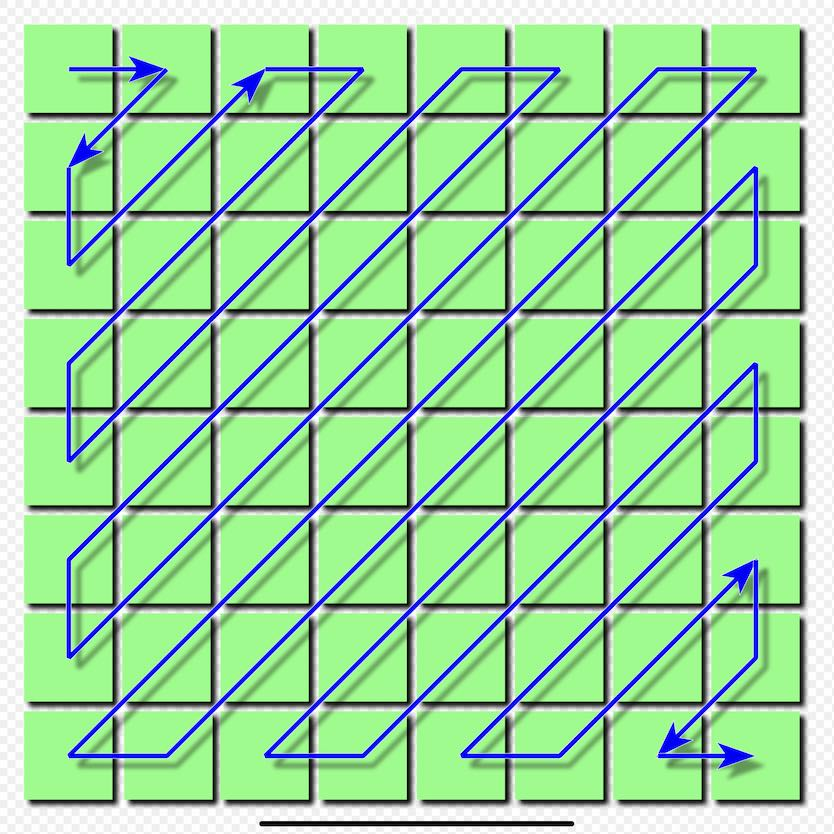

Na prática, consegue-se uma compressão ainda maior, aplicando Codificação de Huffman após o RLE.

Mas aqui não vamos tratar de Codificação de Huffman, vamos só até o RLE.

In [ ]:
# percorre um bloco 8x8 em zigue-zague e o retorna como um array uni-dimensional de tamanho 64
def dctq8x8_to_dctq64(dctq):
    dctq64 = np.zeros((64,), 'int16')
    i, j = 0, 0
    direcao = 1

    for k in range(32):
        dctq64[k] = dctq[i, j]
        if direcao == 1 and i == 0:
            j += 1
            direcao = -1
        elif direcao == -1 and j == 0:
            i += 1
            direcao = 1
        else:
            i -= direcao
            j += direcao

    for k in range(32, 64):
        dctq64[k] = dctq[i, j]
        if direcao == 1 and j == 7:
            i += 1
            direcao = -1
        elif direcao == -1 and i == 7:
            j += 1
            direcao = 1
        else:
            i -= direcao
            j += direcao

    return dctq64

Testando a função acima:

In [ ]:
# teste da função que percorre um bloco 8x8 em zigue-zague
dctq = np.array( [[ 1,  2,  6,  7, 15, 16, 28, 29],
                  [ 3,  5,  8, 14, 17, 27, 30, 43],
                  [ 4,  9, 13, 18, 26, 31, 42, 44],
                  [10, 12, 19, 25, 32, 41, 45, 54],
                  [11, 20, 24, 33, 40, 46, 53, 55],
                  [21, 23, 34, 39, 47, 52, 56, 61],
                  [22, 35, 38, 48, 51, 57, 60, 62],
                  [36, 37, 49, 50, 58, 59, 63, 64]], 'int16')
print('dctq =')
print(dctq)
print('\nPercorrendo essa matriz de DCTs quantizados em zigue-zague:')
print('\ndctq8x8_to_dctq64(dctq) =')
print(dctq8x8_to_dctq64(dctq))

In [ ]:
# retorna a posição do último elemento não nulo em um array uni-dimensional
# se todos os elementos forem nulos, retorna -1
def posicao_ultimo_nao_nulo_array1D(a):
    k = len(a) - 1
    while k >= 0:
        if a[k] != 0:
            return k
        k -= 1
    return -1

A função a seguir retorna quantos bits, sem contar o bit de sinal, são necessários para armazenar um número inteiro de 16 bits passado como argumento.

In [ ]:
# cria um array de potências de 2 negativas de -2^1 a -2^15
potencias_2_negativas = np.zeros((15,), 'int16')
pot = -2
for k in range(15):
    potencias_2_negativas[k] = pot
    pot *= 2

# cria um array de potências de 2 positivas menos um, de (2^1 - 1) a (2^15 - 1)
potencias_2_positivas_menos_um = -(potencias_2_negativas + 1)
print('potencias_2_negativas =')
print(potencias_2_negativas)
print('\npotencias_2_positivas_menos_um =')
print(potencias_2_positivas_menos_um)

# retorna quantos bits, sem contar o bit de sinal, são necessários para armazenar 'x'
# no caso do valor 0, retorna 0
def qtde_bits_int16(x):
    if x == 0:
        return 0
    if x < 0:
        for k in range(15):
            if x >= potencias_2_negativas[k]:
                return k + 1
    else:
        for k in range(15):
            if x <= potencias_2_positivas_menos_um[k]:
                return k + 1

Finalmente, vamos implementar o algoritmo RLE em uma matriz 8x8 de coeficientes DCT quantizados. Essa aqui é apenas uma versão de teste com exibição de mensagens na tela.

In [ ]:
def RLE8x8(dctq, verbose=False):
    if verbose:
        print('Aplicação do algoritmo RLE na matriz de DCTs quantizados:')

    # transforma a matriz 8x8 de DCTs em um array uni-dimensional de tamanho 64
    dctq64 = dctq8x8_to_dctq64(dctq)

    # obtém a posição do último elemento não nulo
    dctq64_posicao_ultimo_nao_nulo = posicao_ultimo_nao_nulo_array1D(dctq64)
    if verbose:
        print('\nPosição do último elemento não nulo, de 0 a 63 ' + \
              '(valor -1 indica que todos são nulos) =', dctq64_posicao_ultimo_nao_nulo)
        print()

    if dctq64_posicao_ultimo_nao_nulo == -1:
        dctq64_posicao_ultimo_nao_nulo = 0

    # percorre 'dctq64' até o último elemento não nulo
    qtde_zeros = 0
    qtde_bits = 0
    for k in range(dctq64_posicao_ultimo_nao_nulo + 1):
        x = dctq64[k]
        if k == 0:  # correspondente à posição dctq[0, 0]
            if x == 0:
                if verbose:
                    print(f'(SIZE) = (0) ===> 4 bits')
                qtde_bits += 4
            else:
                qtde_bits_x = qtde_bits_int16(x)
                if verbose:
                    print(f'(SIZE) (VALUE) = ({qtde_bits_x}) ({x}) ===> {qtde_bits_x + 5} bits')
                qtde_bits += qtde_bits_x + 5
            continue
        if x == 0:  # dctq64[k] é igual a 0
            qtde_zeros += 1
            continue
        while qtde_zeros > 15:
            if verbose:
                print('(RUNLENGTH, SIZE) = (15, 0) ===> 8 bits')
            qtde_zeros -= 15
            qtde_bits += 8
        # qtde_zeros é menor ou igual a 15
        qtde_bits_x = qtde_bits_int16(x)
        if verbose:
            print(f'(RUNLENGTH, SIZE) (VALUE) = ({qtde_zeros}, {qtde_bits_x}) ({x}) ' + \
                  f'===> {qtde_bits_x + 9} bits')
        qtde_zeros = 0
        qtde_bits += qtde_bits_x + 9

    if verbose:
        print('(RUNLENGTH, SIZE) = EOB = (0, 0) ===> 8 bits')
    qtde_bits += 8

    # calcula a quantidade de bytes necessários
    qtde_bytes = -(-qtde_bits // 8)

    if verbose:
        print(f'\nTotal de bits = {qtde_bits} bits.')
        print(f'Total de bytes = {qtde_bytes} bytes ({qtde_bytes * 8} bits).')
        print('A matriz original 8x8 de pixels monocromáticos sempre ocupa 64 bytes (1 byte/pixel).')
        print('Portanto este bloco 8x8 de DCTs codificados com RLE ' + \
              'ocupa {:.1f}% da quantidade de bytes original.'.format(qtde_bytes / 0.64))
    return qtde_bytes

Testando a função de RLE com uma matriz de DCTs formada apenas por zeros:

In [ ]:
# matriz de DCTs quantizados com todos os elementos iguais a zero
dctq = np.zeros((8, 8), 'int16')

print('dctq =')
print(dctq)
print()
qtde_bytes = RLE8x8(dctq, verbose=True)

Testando a função de RLE com uma matriz de pixels pretos (todos iguais a -128):

In [ ]:
pixels_pretos = -128 * np.ones((8, 8), 'int8')
print('pixels_pretos =')
print(pixels_pretos)

# dct sem quantização (equivalente a quantização com qualidade = 100)
qualidade = 100
Q = matriz_quantização(qualidade)
pixels_pretos_dctq = dct8x8T_quant(pixels_pretos, Q)
print('\npixels_pretos_dctq =')
print(pixels_pretos_dctq)
print()

qtde_bytes = RLE8x8(pixels_pretos_dctq, verbose=True)

Testando a função de RLE com um exemplo da Wikipedia:

In [ ]:
dctq = np.array( [[-26, -3, -6,  2,  2, -1,  0,  0],
                  [  0, -2, -4,  1,  1,  0,  0,  0],
                  [ -3,  1,  5, -1, -1,  0,  0,  0],
                  [ -3,  1,  2, -1,  0,  0,  0,  0],
                  [  1,  0,  0,  0,  0,  0,  0,  0],
                  [  0,  0,  0,  0,  0,  0,  0,  0],
                  [  0,  0,  0,  0,  0,  0,  0,  0],
                  [  0,  0,  0,  0,  0,  0,  0,  0]], 'int16')

print('dctq =')
print(dctq)
print()
qtde_bytes = RLE8x8(dctq, verbose=True)

Testando a função de RLE com algumas matrizes de exemplos anteriores:

In [ ]:
# matriz 8x8 com saltos de -128 a +127 entre pixels vizinhos de uma mesma linha
p2 = p2.astype('int8')
print('p2 =')
print(p2)

# dct sem quantização (equivalente a quantização com qualidade = 100)
print('\np2_dct =')
print(p2_dct)
print()

qtde_bytes = RLE8x8(p2_dct, verbose=True)

In [ ]:
# matriz 8x8 com saltos de -128 a +127 entre pixels vizinhos de uma mesma coluna
# p3 = p2.transpose()
p3 = p3.astype('int8')
print('p3 =')
print(p3)

# dct sem quantização (equivalente a quantização com qualidade = 100)
print('\np3_dct =')
print(p3_dct)
print()

qtde_bytes = RLE8x8(p3_dct, verbose=True)

In [ ]:
print('Ruído aleatório 8x8 no intervalo de -32 a +31, acrescido da constante 50:')
print('\np1_suavizada.dtype =', p1_suavizada.dtype)
print('p1_suavizada =')
print(p1_suavizada)

qualidade = 50
Q = matriz_quantização(qualidade)
p1_suavizada_dctq = dct8x8T_quant(p1_suavizada, Q)

print(f'\nAplicando DCT e em seguida quantização com qualidade = {qualidade}:')
print('\np1_suavizada_dctq =')
print(p1_suavizada_dctq)
print()
qtde_bytes = RLE8x8(p1_suavizada_dctq, verbose=True)

Vamos agora implementar duas funções: a primeira recebe uma imagem completa (com valores de 0 a 255) e retorna os seus coeficientes DCT quantizados, a outra função faz a operação inversa. Assim testaremos o algoritmo de DCT com quantização em uma imagem real completa, não apenas em um bloco 8x8 de pixels.

Vamos também calcular quantos bytes "seriam" usados se armazenássemos os coeficientes DCT quantizados com RLE (note que não estamos de fato armazenando os DCTs usando RLE, isso não foi implementado no código).

In [ ]:
def img_dct8x8T_quant(img, qualidade):
    # converte 'img' de uint8 (0 a 255) para int8 (-128 a +127)
    img = (img.astype('int16') - 128).astype('int8')
    Q = matriz_quantização(qualidade)
    qtde_linhas  = int(img.shape[0] / 8)
    qtde_colunas = int(img.shape[1] / 8)
    qtde_bytes = 0
    if img.ndim == 2:
        img_dctq = np.zeros((8 * qtde_linhas, 8 * qtde_colunas), 'int16')
        for i in range(qtde_linhas):
            for j in range(qtde_colunas):
                dctq8x8 = dct8x8T_quant(img[8*i:8*(i+1), 8*j:8*(j+1)], Q)
                qtde_bytes += RLE8x8(dctq8x8)
                img_dctq[8*i:8*(i+1), 8*j:8*(j+1)] = dctq8x8
    else:
        img_dctq = np.zeros((8 * qtde_linhas, 8 * qtde_colunas, img.shape[2]), 'int16')
        for i in range(qtde_linhas):
            for j in range(qtde_colunas):
                for k in range(img.shape[2]):
                    dctq8x8 = dct8x8T_quant(img[8*i:8*(i+1), 8*j:8*(j+1), k], Q)
                    qtde_bytes += RLE8x8(dctq8x8)
                    img_dctq[8*i:8*(i+1), 8*j:8*(j+1), k] = dctq8x8
    return img_dctq, qtde_bytes

def img_idct8x8T_quant(img_dctq, qualidade):
    Q = matriz_quantização(qualidade)
    qtde_linhas  = int(img_dctq.shape[0] / 8)
    qtde_colunas = int(img_dctq.shape[1] / 8)
    if img_dctq.ndim == 2:
        img = np.zeros((8 * qtde_linhas, 8 * qtde_colunas), 'int8')
        for i in range(qtde_linhas):
            for j in range(qtde_colunas):
                img8x8 = idct8x8T_quant(img_dctq[8*i:8*(i+1), 8*j:8*(j+1)], Q)
                img[8*i:8*(i+1), 8*j:8*(j+1)] = img8x8
    else:
        img = np.zeros((8 * qtde_linhas, 8 * qtde_colunas, img_dctq.shape[2]), 'int8')
        for i in range(qtde_linhas):
            for j in range(qtde_colunas):
                for k in range(img_dctq.shape[2]):
                    img8x8 = idct8x8T_quant(img_dctq[8*i:8*(i+1), 8*j:8*(j+1), k], Q)
                    img[8*i:8*(i+1), 8*j:8*(j+1), k] = img8x8
    # converte 'img' de int8 (-128 a +127) para uint8 (0 a 255)
    img = (img.astype('int16') + 128).astype('uint8')
    return img

Vamos testar as funções acima.

In [ ]:
# função de teste com uma imagem
def teste_img(img):
    if img.ndim > 2:
        if img.shape[2] > 3:
            print('Imagem não permitida: provavelmente ela possui um canal alpha.')
            return
    qtde_bytes_sem_compressao = 1
    for k in range(img.ndim):
        qtde_bytes_sem_compressao *= img.shape[k]
    qtde_Kbytes_sem_compressao = qtde_bytes_sem_compressao  / 1000.0
    qtde_Gbytes_sem_compressao = qtde_Kbytes_sem_compressao / 1000.0

    print('Imagem original:')
    print('img.shape =', img.shape)
    print(f'Quantidade de bytes sem compressão = {qtde_Kbytes_sem_compressao:.1f} KB = ' + \
          f'{qtde_Gbytes_sem_compressao:.3f} GB')
    display(Image.fromarray(img))

    qualidades = [1, 10, 30, 50, 70, 90, 100]
    for qualidade in qualidades:
        img_dctq, qtde_bytes = img_dct8x8T_quant(img, qualidade)
        img_dctq_idctq = img_idct8x8T_quant(img_dctq, qualidade)
        qtde_Kbytes = qtde_bytes  / 1000.0
        qtde_Gbytes = qtde_Kbytes / 1000.0
        qtde_percentual_bytes = qtde_bytes * 100.0 / qtde_bytes_sem_compressao
        print(f'\n\nImagem com DCT e quantização com qualidade = {qualidade}:')
        print(f'Quantidade de bytes = {qtde_Kbytes:.1f} KB = {qtde_Gbytes:.3f} GB = ' + \
              f'{qtde_percentual_bytes:.1f}% da quantidade original de bytes sem compressão.')
        # comparamos o resultado com img
        print('Máximo erro absoluto entre os pixels de img e de img_dctq_idctq =', \
              abs(img_dctq_idctq.astype('int16') - img.astype('int16')).max())
        display(Image.fromarray(img_dctq_idctq))

In [ ]:
# clona o github da disciplina EA979 da professora Paula Costa para acesso a imagens
!git clone https://github.com/pdpcosta/teaching-ea979.git

In [ ]:
img1 = np.asarray(Image.open('./teaching-ea979/images/flower.pgm'))
teste_img(img1)

In [ ]:
img2 = np.asarray(Image.open('./teaching-ea979/images/orquideafeec-calua.jpeg'))
teste_img(img2)

In [ ]:
# clona o github deste projeto para acesso a imagens
!git clone https://github.com/brfernandobr/DCT-Image-Compression.git

In [ ]:
img3 = np.asarray(Image.open('./DCT-Image-Compression/imagens/Hulk.png'))
teste_img(img3)

In [ ]:
img4 = np.asarray(Image.open('./DCT-Image-Compression/imagens/Captain America.png'))
teste_img(img4)